### **Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

*Implementation Step 1 : Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.*

In [1]:
#Imports
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pickle
from scipy.signal import find_peaks_cwt

import helper
%matplotlib inline


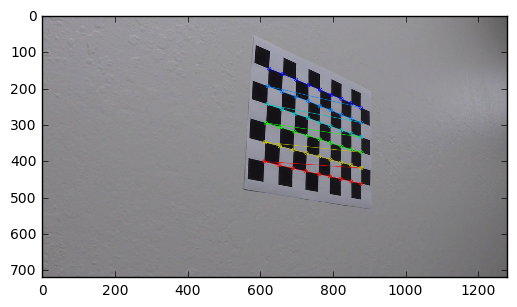

In [2]:
nx = 9
ny = 6
cal_img_location = 'camera_cal/calibration*.jpg'
confPickleFileName = 'camera_conf.pkl'
img = helper.cameraPropFinder(nx,ny,cal_img_location,confPickleFileName)
#Show the last image returned
plt.imshow(img)

Implementation# Step 2 : Apply a distortion correction to raw images.

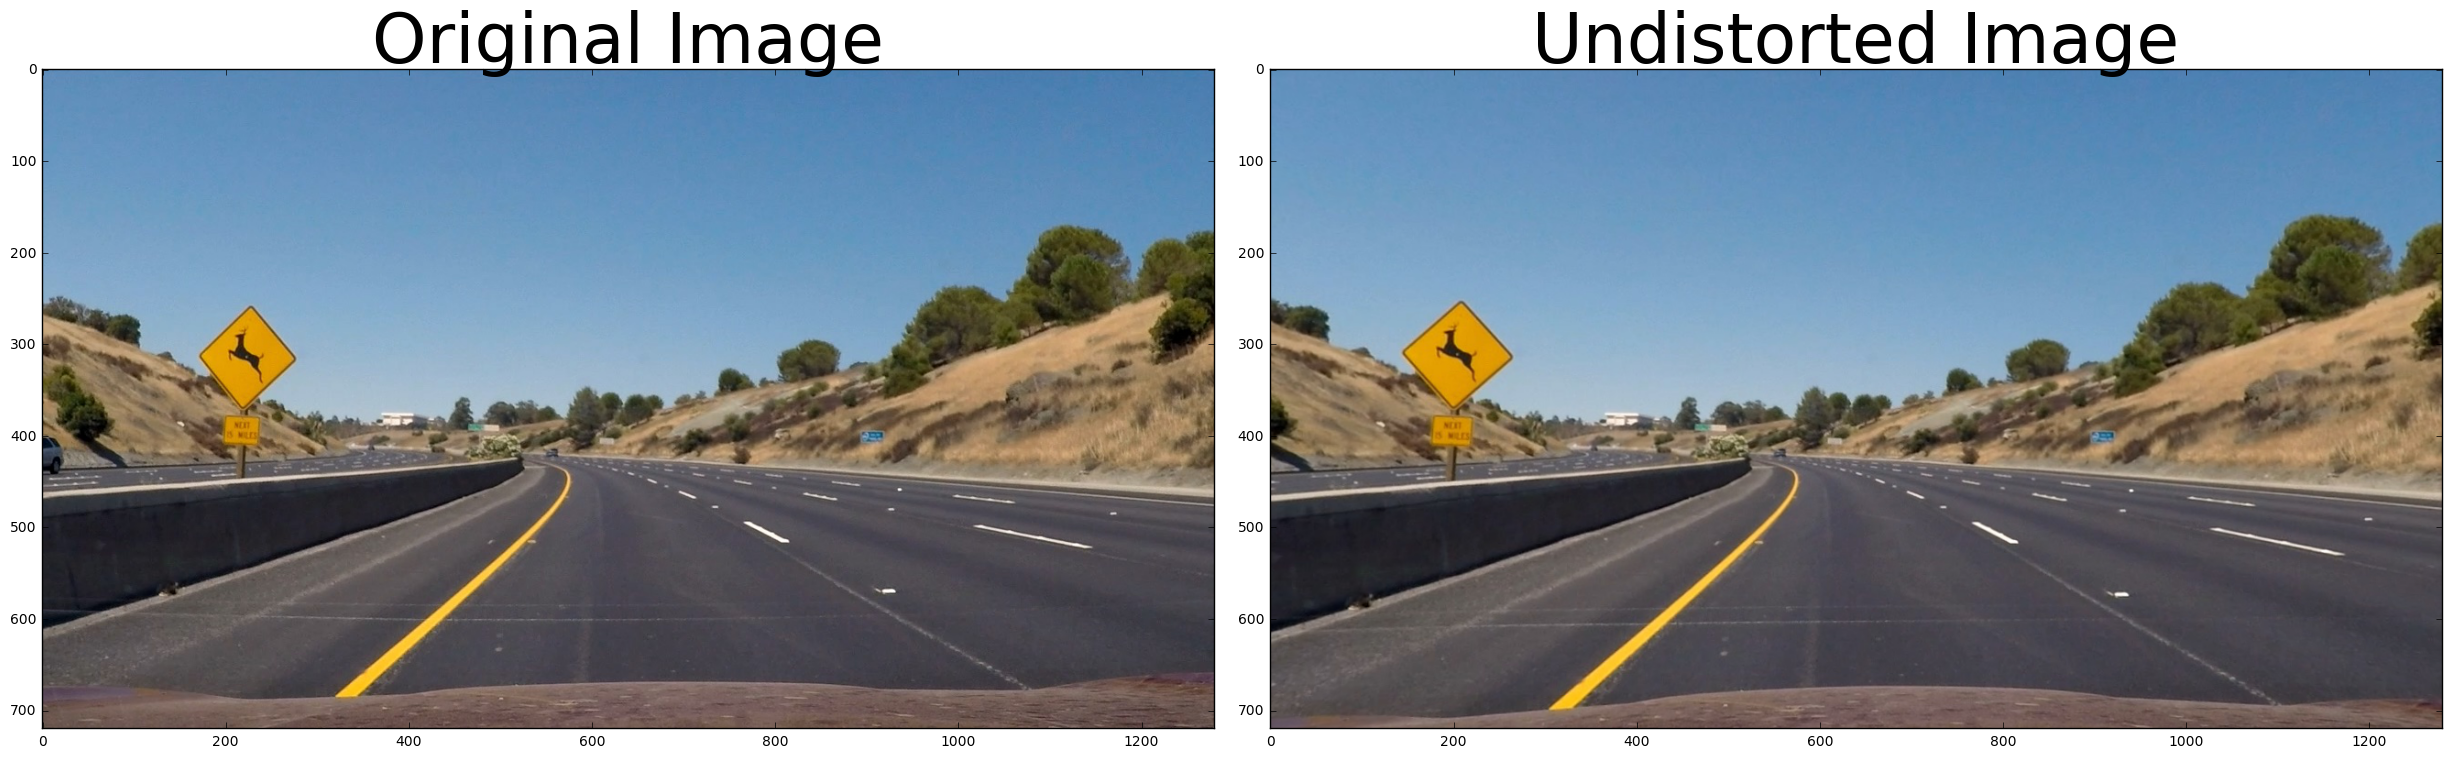

In [3]:
#Load the camera matrix and distortion coefficient
data = pickle.load( open( confPickleFileName, "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]

# Next we read in image 
image = mpimg.imread('test_images/test2.jpg')
undistorted = helper.undistort(image,mtx_camera,dist_camera)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Implementation Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
img_size = np.shape(image)
#Select a trapezoid around the lane which needs to warped 
top_y = np.uint(img_size[0]/1.5)
bottom_y = np.uint(img_size[0])
center = np.uint(img_size[1]/2)
top_leftx = center - .2*np.uint(img_size[1]/2)
top_rightx = center + .2*np.uint(img_size[1]/2)
bottom_leftx = center - .9*np.uint(img_size[1]/2)
bottom_rightx = center + .9*np.uint(img_size[1]/2)

src = np.float32([[bottom_leftx,bottom_y],[bottom_rightx,bottom_y],[top_rightx,top_y],[top_leftx,top_y]])
dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],[img_size[1],0],[0,0]])

#Warp the image using wrap_image using cv2.getPerspectiveTransform and cv2.warpPerspective functions
warped,M_warp,Minv_warp = helper.warp_image(image,src,dst)

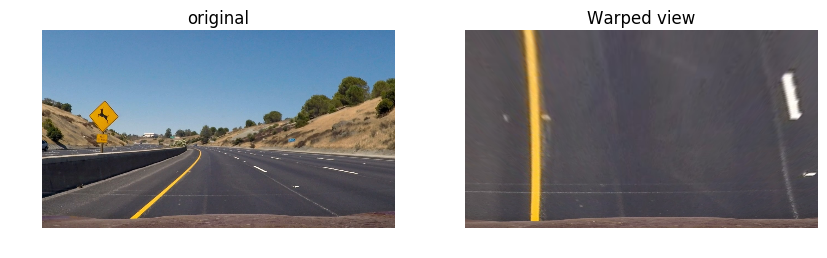

In [5]:
#Visulize the original and the warped image
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(warped,cmap='gray')  
plt.title('Warped view')
plt.axis('off');

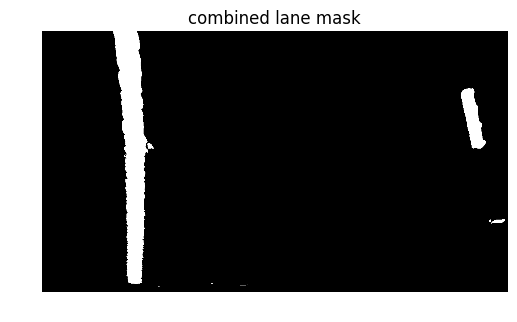

In [6]:
# Covert the image to HSV color space
# We are going to experiment in the HSV and HLS color space as its lightness component varies the most
# under different lightning condition but its Hue and Saturation channel stay fairly consistent in shadow or excessive brightness.
# This allows us to detect different color lane lines more realiabily than in any other color space.

image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
# Define color ranges and apply color mask
yellow_hsv_low  = np.array([ 0, 100, 100])
yellow_hsv_high = np.array([ 50, 255, 255])
white_hsv_low  = np.array([ 0,   0,   160])
white_hsv_high = np.array([ 255,  80, 255])
mask_yellow = helper.color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
mask_white = helper.color_mask(image_HSV,white_hsv_low,white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask')
plt.axis('off');

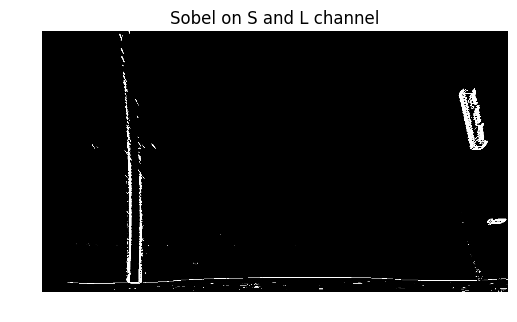

In [7]:
# Convert image to HLS scheme 
image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

# Lane lines tend to be close to be vertical. So we need to detect steep edges that are more likely to be a lane
# Applying the Sobel operator to an image is a way of taking the derivative of the image in the x or y direction. 
# Taking the gradient in the x direction emphasizes edges closer to vertical. 
# Alternatively, taking the gradient in the y direction emphasizes edges closer to horizontal.

# helper.abs_sobel_thresh takes in an image and optional Sobel kernel size, as well as thresholds for gradient magnitude. 


# Apply sobel filters on L and S channels.
img_gs = image_HLS[:,:,1]
img_abs_x = helper.abs_sobel_thresh(img_gs,'x',5,(50,225))
img_abs_y = helper.abs_sobel_thresh(img_gs,'y',5,(50,225))
wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

img_gs = image_HLS[:,:,2]
img_abs_x = helper.abs_sobel_thresh(img_gs,'x',5,(50,255))
img_abs_y = helper.abs_sobel_thresh(img_gs,'y',5,(50,255))
wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))    

# Combine sobel filter information from L and S channels.
image_cmb = cv2.bitwise_or(wraped2,wraped3)

plt.imshow(image_cmb,cmap='gray')
plt.title('Sobel on S and L channel')
plt.axis('off');

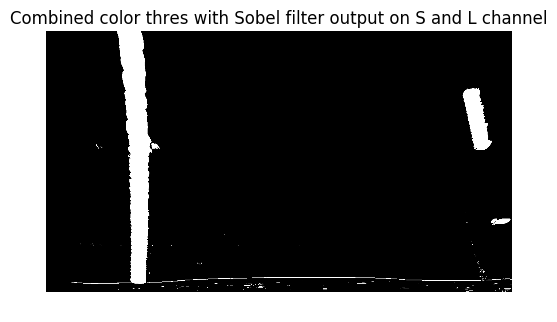

In [8]:
image_cmb1 = np.zeros_like(image_cmb)
image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1
plt.imshow(image_cmb1,cmap='gray')
plt.title('Combined color thres with Sobel filter output on S and L channel')
plt.axis('off');

C:\Program Files\Anaconda3\envs\CarND-Traffic-Sign-Classifier-Project_env\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\e526340\selfcar\arena\CarND-Advanced-Lane-Lines-master\helper.py:155: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ret[n:] = ret[n:] - ret[:-n]
C:\Users\e526340\selfcar\arena\CarND-Advanced-Lane-Lines-master\helper.py:156: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return ret[n - 1:] / n
C:\Program Files\Anaconda3\envs\CarND-Traffic-Sign-Classifier-Project_env\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1280)

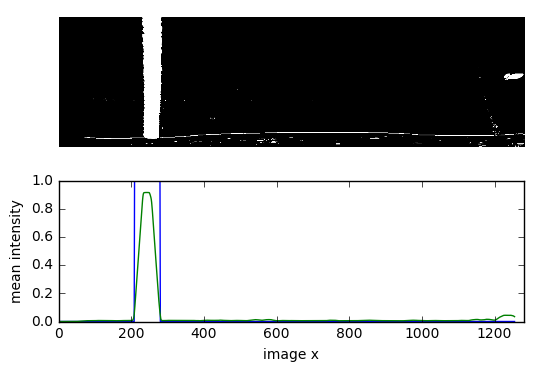

In [9]:
# The entire width is divided into 50 regions. We use moving average and then use scipy's find_peaks_cwt function
# to find the indexs of the peaks

mov_filtsize = img_size[1]/50.
mean_lane = np.mean(image_cmb1[img_size[0]/2:,:],axis=0)
mean_lane = helper.moving_average(mean_lane,mov_filtsize)

plt.subplot(2,1,1)
plt.imshow(image_cmb1[img_size[0]/2:,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])

In [10]:
# Take a histogram of the bottom half of the image
binary_warped = image_cmb1
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

C:\Program Files\Anaconda3\envs\CarND-Traffic-Sign-Classifier-Project_env\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(720, 0)

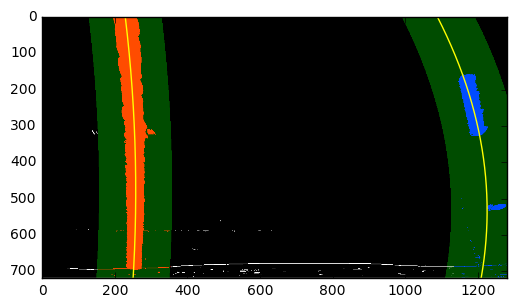

In [11]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [103]:
def pipeline_lane_finder(image):
    
    image = helper.undistort(image,mtx_camera,dist_camera)
    img_size = np.shape(image)
    img_size = np.shape(image)
    
    #Select a trapezoid around the lane which needs to warped 
    top_y = np.uint(img_size[0]/1.5)
    bottom_y = np.uint(img_size[0])
    center = np.uint(img_size[1]/2)
    top_leftx = center - .2*np.uint(img_size[1]/2)
    top_rightx = center + .2*np.uint(img_size[1]/2)
    bottom_leftx = center - .9*np.uint(img_size[1]/2)
    bottom_rightx = center + .9*np.uint(img_size[1]/2)

    src = np.float32([[bottom_leftx,bottom_y],[bottom_rightx,bottom_y],[top_rightx,top_y],[top_leftx,top_y]])
    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],[img_size[1],0],[0,0]])

    #Warp the image using wrap_image using cv2.getPerspectiveTransform and cv2.warpPerspective functions
    warped,M_warp,Minv_warp = helper.warp_image(image,src,dst)

    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    # Define color ranges and apply color mask
    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])
    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])
    # get yellow and white masks 
    mask_yellow = helper.color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = helper.color_mask(image_HSV,white_hsv_low,white_hsv_high)
    # Combine white and yellow masks into 1
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 
    # Convert image to HLS scheme
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    # Apply sobel filters on L and S channels.
    img_gs = image_HLS[:,:,1]
    img_abs_x = helper.abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = helper.abs_sobel_thresh(img_gs,'y',5,(50,225))
    wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    img_abs_x = helper.abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = helper.abs_sobel_thresh(img_gs,'y',5,(50,255))
    wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    # Combine sobel filter information from L and S channels.
    image_cmb = cv2.bitwise_or(wraped2,wraped3)
    
    # Combine masks from sobel and color masks.
    image_cmb1 = np.zeros_like(image_cmb)
    image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1
    
    binary_warped = image_cmb1
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    
    
    fit_y = np.linspace(0, window_img.shape[0] - 1, window_img.shape[0])

    pts_left = np.array([np.transpose(np.vstack([left_fitx, fit_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fit_y])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(window_img, np.int_([pts]), (0, 0, 255))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
    newwarp = cv2.warpPerspective(result, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    ## Compute intercepts
    left_bot = helper.get_val(img_size[0],left_fit)
    right_bot = helper.get_val(img_size[0],right_fit)
    
    ## Compute center location
    val_center = (left_bot+right_bot)/2.0

    ## Compute lane offset
    dist_offset = val_center - img_size[1]/2
    dist_offset = np.round(dist_offset/2.81362,2)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    y_eval = np.max(ploty)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
 
    str_curv = 'Curvature: Right = ' + str(np.round(right_curverad,2)) + 'm, Left = ' + str(np.round(left_curverad,2))+'m' 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, str_curv, (30, 60), font, 1, (0,255,0), 2)
    cv2.putText(result, str_offset, (30, 90), font, 1, (0,255,0), 2)
    
    ## Thanks to John Chen for this amazing diagnostic view idea  - 
    # https://carnd-forums.udacity.com/cq/viewquestion.action?id=32706990&questionTitle=want-to-create-a-diagnostic-view-into-your-lane-finding-pipeline

    if do_diagnosis == 1:
        font = cv2.FONT_HERSHEY_COMPLEX
        middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
        cv2.putText(middlepanel, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
        mainDiagScreen = result
        diag1 = warped
        diag2 = image_HSV
        diag3 = stack_arr(mask_lane)
        diag4 = stack_arr(mask_white)
        diag5 = helper.apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high)
        diag6 = out_img
        diag7 = helper.color_mask(image_HSV,white_hsv_low,white_hsv_high)
        diag8 = window_img
        diag9 = newwarp
        

        # assemble the screen example
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:720, 0:1280] = mainDiagScreen
        diagScreen[0:240, 1280:1600] = cv2.resize(diag1, (320,240), interpolation=cv2.INTER_AREA) 
        diagScreen[0:240, 1600:1920] = cv2.resize(diag2, (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1280:1600] = cv2.resize(diag3, (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1600:1920] = cv2.resize(diag4, (320,240), interpolation=cv2.INTER_AREA)*4
        diagScreen[720:840, 0:1280] = middlepanel
        diagScreen[840:1080, 0:320] = cv2.resize(diag5, (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 320:640] = cv2.resize(diag6, (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 640:960] = cv2.resize(diag9, (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 960:1280] = cv2.resize(diag8, (320,240), interpolation=cv2.INTER_AREA)
    
        return diagScreen
    else:
        return result


(720, 1280, 3)


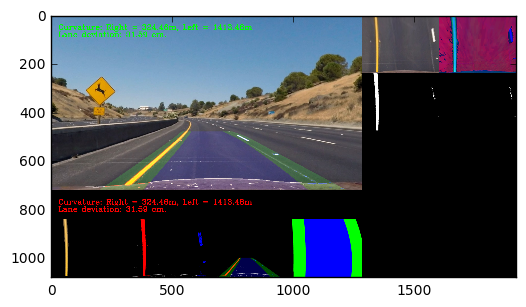

In [104]:
def stack_arr(arr):
    # Stacks 1-channel array into 3-channel array to allow plotting
    return np.stack((arr, arr,arr), axis=2)

do_diagnosis = 1
result_pipe = pipeline_lane_finder(image)
plt.imshow(result_pipe)

In [99]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [100]:
project_output = 'project_video_output111.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(pipeline_lane_finder) 
%time white_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_video_output111.mp4
[MoviePy] Writing video project_video_output111.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:19<00:00,  3.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output111.mp4 

Wall time: 6min 22s
